# Amplitude model with `ampform`

PWA study on $p \gamma \to \Lambda K^+ \pi^0$.
We formulate the helicity amplitude model symbolically using `AmpForm` here.

In [1]:
import logging
import os
import warnings
from collections import defaultdict
from fractions import Fraction
from textwrap import dedent

import ampform
import graphviz
import ipywidgets as w
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import qrules
import sympy as sp
from ampform.dynamics.builder import RelativisticBreitWignerBuilder
from ampform.io import aslatex, improve_latex_rendering
from IPython.display import SVG, Image, Markdown, Math, display
from qrules.particle import Particle, Spin, create_particle, load_pdg
from tensorwaves.data import (
    SympyDataTransformer,
    TFPhaseSpaceGenerator,
    TFUniformRealNumberGenerator,
)
from tensorwaves.function.sympy import create_parametrized_function

STATIC_PAGE = "EXECUTE_NB" in os.environ

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

improve_latex_rendering()
particle_db = load_pdg()

## Decay definition

### Particle definitions

In [2]:
def generate_markdown_table(particles: list[str]):
    src = dedent(r"""
    | Particle | Name | PID | $J^{PC} (I^G)$ | $I_3$ | $M$ | $\Gamma$ | $Q$ | $S$ | $B$ |
    | :------- |------|-----|----------------|-------|-----|----------|-----|-----|-----|
    """)
    for name in particles:
        p = particle_db[name]
        src += f"| ${p.latex}$ | `{p.name}` | {p.pid} | {jpc_ig(p)} | {i_3(p)} |  {p.mass:.3g}| {p.width:g} | {p.charge} |{p.strangeness} | {p.baryon_number}|\n"
    return src


def jpc_ig(particle: Particle) -> str:
    j = format_fraction(particle.spin)
    p = format_parity(particle.parity)
    c = format_parity(particle.c_parity)
    if particle.isospin is None:
        return f"${j}^{{{p}{c}}}$"
    i = format_fraction(particle.isospin.magnitude)
    g = format_parity(particle.g_parity)
    return rf"${j}^{{{p}{c}}} \; ({i}^{{{g}}})$"


def i_3(particle: Particle) -> str:
    if particle.isospin is None:
        return "N/A"
    return f"${format_fraction(particle.isospin.projection)}$"


def format_fraction(value: float) -> str:
    value = Fraction(value)
    if value.denominator == 1:
        return str(value.numerator)
    return rf"\frac{{{value.numerator}}}{{{value.denominator}}}"


def format_parity(parity: int | None) -> str:
    if parity is None:
        return " "
    if parity == -1:
        return "-"
    if parity == 1:
        return "+"
    raise NotImplementedError


particles = ["Lambda", "K+", "pi0", "gamma", "p"]
src = generate_markdown_table(particles)
Markdown(src)


| Particle | Name | PID | $J^{PC} (I^G)$ | $I_3$ | $M$ | $\Gamma$ | $Q$ | $S$ | $B$ |
| :------- |------|-----|----------------|-------|-----|----------|-----|-----|-----|
| $\Lambda$ | `Lambda` | 3122 | $\frac{1}{2}^{+ } \; (0^{ })$ | $0$ |  1.12| 2.515e-15 | 0 |-1 | 1|
| $K^{+}$ | `K+` | 321 | $0^{- } \; (\frac{1}{2}^{ })$ | $\frac{1}{2}$ |  0.494| 5.317e-17 | 1 |1 | 0|
| $\pi^{0}$ | `pi0` | 111 | $0^{-+} \; (1^{-})$ | $0$ |  0.135| 7.81e-09 | 0 |0 | 0|
| $\gamma$ | `gamma` | 22 | $1^{--}$ | N/A |  0| 0 | 0 |0 | 0|
| $p$ | `p` | 2212 | $\frac{1}{2}^{+ } \; (\frac{1}{2}^{ })$ | $\frac{1}{2}$ |  0.938| 0 | 1 |0 | 1|


In the table above, PID is the PDG ID from PDG particle numbering scheme,
$J$ is the spin, $P$ is the parity, $C$ is the C parity, $I$ is the isospin (magnitude), $G$ is the G parity.
$I_3$ is the isospin projection (or the 3rd component),
$M$ is the mass,
$\Gamma$ is the width,
$Q$ is the charge,
$S$ is the strangeness number,
and $B$ is the baryon number.

### Initial state definition

Mass for $p \gamma$ system

In [3]:
E_lab_gamma = 8.5
m_proton = 0.938
m_0 = np.sqrt(2 * E_lab_gamma * m_proton + m_proton**2)
m_eta = 0.548
m_pi = 0.135
m_0

np.float64(4.101931740046389)

Add custom particle $p \gamma$

In [4]:
pgamma1 = Particle(
    name="pgamma1",
    latex=r"p\gamma (s1/2)",
    spin=0.5,
    mass=m_0,
    charge=1,
    isospin=Spin(1 / 2, +1 / 2),
    baryon_number=1,
    parity=-1,
    pid=99990,
)
pgamma2 = create_particle(
    template_particle=pgamma1,
    name="pgamma2",
    latex=R"p\gamma (s3/2)",
    spin=1.5,
    pid=pgamma1.pid + 1,
)
particle_db.update([pgamma1, pgamma2])

### Generate transitions

For simplicity, we use the initial state $p \gamma$ (with spin-$\frac{1}{2}$), 
and set the allowed interaction type to be strong only,
the formalism is selected to be helicity formalism instead of canonical.

:::{seealso}
[Helicity versus canonical](https://ampform.readthedocs.io/stable/usage/helicity/formalism.html)
:::

In [5]:
reaction = qrules.generate_transitions(
    initial_state=("pgamma1"),
    final_state=["Lambda", "K+", "pi0"],
    allowed_interaction_types=["strong"],
    formalism="helicity",
    particle_db=particle_db,
    max_angular_momentum=4,
    max_spin_magnitude=4,
    mass_conservation_factor=0,
)

Propagating quantum numbers:   0%|          | 0/12 [00:00<?, ?it/s]

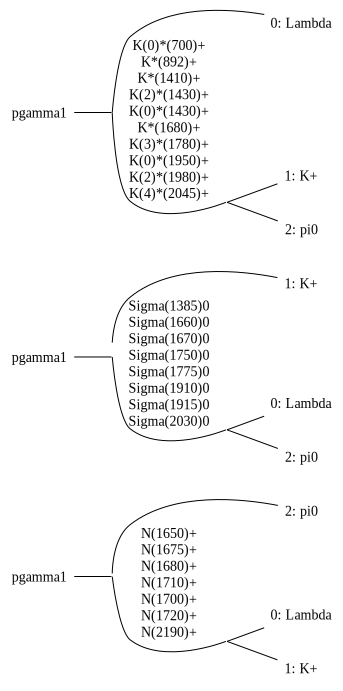

In [6]:
dot = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(dot)

## Formulate amplitude model

In [7]:
model_builder = ampform.get_builder(reaction)
model_builder.config.scalar_initial_state_mass = True
model_builder.config.stable_final_state_ids = 0, 1, 2
bw_builder = RelativisticBreitWignerBuilder(
    energy_dependent_width=False,
    form_factor=False,
)
for name in reaction.get_intermediate_particles().names:
    model_builder.dynamics.assign(name, bw_builder)
model = model_builder.formulate()

In [8]:
model.intensity

PoolSum(Abs(A^01[m_A, m0, m1, m2] + A^02[m_A, m0, m1, m2] + A^12[m_A, m0, m1, m2])**2, (m_A, (1/2, -1/2)), (m0, (1/2, -1/2)), (m1, (0,)), (m2, (0,)))

The first term in the amplitude model:

In [9]:
(symbol, expr), *_ = model.amplitudes.items()
Math(aslatex({symbol: expr}, terms_per_line=1))

<IPython.core.display.Math object>

In [10]:
Math(aslatex(model.parameter_defaults))

<IPython.core.display.Math object>

In [11]:
Math(aslatex(model.kinematic_variables))

<IPython.core.display.Math object>

## Visualization

In [12]:
unfolded_expression = model.expression.doit()
intensity_func = create_parametrized_function(
    expression=unfolded_expression,
    parameters=model.parameter_defaults,
    backend="jax",
)

In [13]:
phsp_event = 500_000
rng = TFUniformRealNumberGenerator(seed=0)
phsp_generator = TFPhaseSpaceGenerator(
    initial_state_mass=reaction.initial_state[-1].mass,
    final_state_masses={i: p.mass for i, p in reaction.final_state.items()},
)
phsp_momenta = phsp_generator.generate(phsp_event, rng)

Generating phase space sample:   0%|          | 0/500000 [00:00<?, ?it/s]

I0000 00:00:1764006119.607815 28619800 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [14]:
helicity_transformer = SympyDataTransformer.from_sympy(
    model.kinematic_variables,
    backend="jax",
)
phsp = helicity_transformer(phsp_momenta)

In [15]:
resonances = defaultdict(set)
for transition in reaction.transitions:
    topology = transition.topology
    top_decay_products = topology.get_edge_ids_outgoing_from_node(0)
    (resonance_id, resonance), *_ = transition.intermediate_states.items()
    recoil_id, *_ = top_decay_products - {resonance_id}
    resonances[recoil_id].add(resonance.particle)
resonances = {k: sorted(v, key=lambda p: p.mass) for k, v in resonances.items()}
{k: [p.name for p in v] for k, v in resonances.items()}

{0: ['K(0)*(700)+',
  'K*(892)+',
  'K*(1410)+',
  'K(2)*(1430)+',
  'K(0)*(1430)+',
  'K*(1680)+',
  'K(3)*(1780)+',
  'K(0)*(1950)+',
  'K(2)*(1980)+',
  'K(4)*(2045)+'],
 1: ['Sigma(1385)0',
  'Sigma(1660)0',
  'Sigma(1670)0',
  'Sigma(1750)0',
  'Sigma(1775)0',
  'Sigma(1910)0',
  'Sigma(1915)0',
  'Sigma(2030)0'],
 2: ['N(1650)+',
  'N(1675)+',
  'N(1680)+',
  'N(1710)+',
  'N(1720)+',
  'N(1700)+',
  'N(2190)+']}

In [16]:
sliders = {}
categorized_sliders_m = defaultdict(list)
categorized_sliders_gamma = defaultdict(list)
categorized_cphi_pair = defaultdict(list)

for symbol, value in model.parameter_defaults.items():
    if symbol.name.startswith(R"\Gamma_{"):
        slider = w.FloatSlider(
            description=Rf"\({sp.latex(symbol)}\)",
            min=0.0,
            max=1.0,
            step=0.01,
            value=value,
            continuous_update=False,
        )
        sliders[symbol.name] = slider
        if symbol.name.startswith(R"\Gamma_{K"):
            categorized_sliders_gamma[0].append(slider)
        elif symbol.name.startswith(R"\Gamma_{\S"):
            categorized_sliders_gamma[1].append(slider)
        elif symbol.name.startswith(R"\Gamma_{N"):
            categorized_sliders_gamma[2].append(slider)

    if symbol.name.startswith("m_{"):
        slider = w.FloatSlider(
            description=Rf"\({sp.latex(symbol)}\)",
            min=0.63,
            max=4,
            step=0.01,
            value=value,
            continuous_update=False,
        )
        sliders[symbol.name] = slider
        if symbol.name.startswith("m_{K"):
            categorized_sliders_m[0].append(slider)
        elif symbol.name.startswith(R"m_{\S"):
            categorized_sliders_m[1].append(slider)
        elif symbol.name.startswith("m_{N"):
            categorized_sliders_m[2].append(slider)

    if symbol.name.startswith("C_{"):
        c_latex = sp.latex(symbol)
        phi_latex = c_latex.replace("C", R"\phi", 1)

        slider_c = w.FloatSlider(
            description=Rf"\({c_latex}\)",
            min=0,
            max=10,
            step=0.01,
            value=abs(value),
            continuous_update=False,
        )
        slider_phi = w.FloatSlider(
            description=Rf"\({phi_latex}\)",
            min=-np.pi,
            max=+np.pi,
            step=0.01,
            value=np.angle(value),
            continuous_update=False,
        )

        sliders[symbol.name] = slider_c
        sliders[symbol.name.replace("C", "phi", 1)] = slider_phi

        cphi_hbox = w.HBox([slider_c, slider_phi])
        if "Sigma" in symbol.name:
            categorized_cphi_pair[1].append(cphi_hbox)
        elif R"\to N" in symbol.name:
            categorized_cphi_pair[2].append(cphi_hbox)
        else:
            categorized_cphi_pair[0].append(cphi_hbox)


assert len(categorized_sliders_gamma) == 3
assert len(categorized_sliders_m) == 3
assert len(categorized_cphi_pair) == 3

subtabs = {}
for category, resonance_list in resonances.items():
    subtabs[category] = []
    for particle in resonance_list:
        m_sliders = [
            slider
            for slider in categorized_sliders_m[category]
            if particle.latex in slider.description
        ]
        gamma_sliders = [
            slider
            for slider in categorized_sliders_gamma[category]
            if particle.latex in slider.description
        ]
        cphi_pairs = [
            hbox
            for hbox in categorized_cphi_pair[category]
            if particle.latex in hbox.children[0].description
        ]
        pole_pair = w.HBox(m_sliders + gamma_sliders)
        resonance_tab = w.VBox([pole_pair, *cphi_pairs])
        subtabs[category].append(resonance_tab)
assert len(subtabs) == 3

main_tabs = []
for category, slider_boxes in subtabs.items():
    sub_tab_widget = w.Tab(children=slider_boxes)
    for i, particle in enumerate(resonances[category]):
        sub_tab_widget.set_title(i, particle.name)

    main_tabs.append(sub_tab_widget)

UI = w.Tab(children=main_tabs, titles=("K*", "Σ*", "N*"))

In [17]:
def insert_phi(parameters: dict) -> dict:
    updated_parameters = {}
    for key, value in parameters.items():
        if key.startswith("phi_"):
            continue
        if key.startswith("C_"):
            phi_key = key.replace("C_", "phi_")
            if phi_key in parameters:
                phi = parameters[phi_key]
                value *= np.exp(1j * phi)  # noqa:PLW2901
        updated_parameters[key] = value
    return updated_parameters

In [18]:
%matplotlib widget

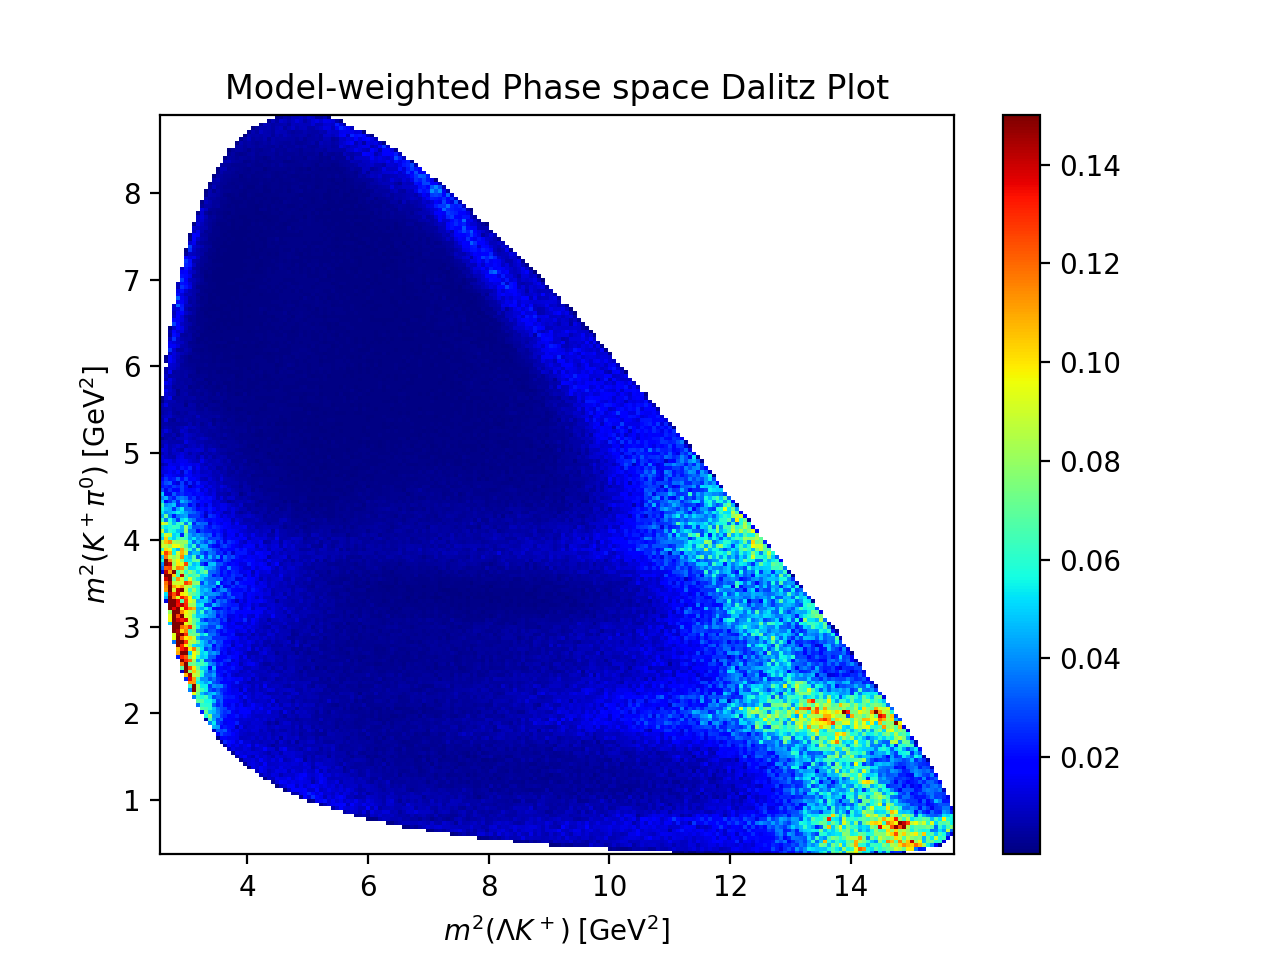

In [19]:
fig_2d, ax_2d = plt.subplots(dpi=200)
ax_2d.set_title("Model-weighted Phase space Dalitz Plot")
ax_2d.set_xlabel(R"$m^2(\Lambda K^+)\;\left[\mathrm{GeV}^2\right]$")
ax_2d.set_ylabel(R"$m^2(K^+ \pi^0)\;\left[\mathrm{GeV}^2\right]$")
fig_2d.canvas.toolbar_visible = False
fig_2d.canvas.header_visible = False
fig_2d.canvas.footer_visible = False

mesh = None


def update_histogram(**parameters):
    global mesh
    parameters = insert_phi(parameters)
    intensity_func.update_parameters(parameters)
    intensity_weights = intensity_func(phsp)
    bin_values, xedges, yedges = jnp.histogram2d(
        phsp["m_01"].real ** 2,
        phsp["m_12"].real ** 2,
        bins=200,
        weights=intensity_weights,
        density=True,
    )
    bin_values = jnp.where(bin_values < 1e-6, jnp.nan, bin_values)
    x, y = jnp.meshgrid(xedges[:-1], yedges[:-1])
    if mesh is None:
        mesh = ax_2d.pcolormesh(x, y, bin_values.T, cmap="jet", vmax=0.15)
    else:
        mesh.set_array(bin_values.T)
    fig_2d.canvas.draw()


w.interactive_output(update_histogram, sliders)
fig_2d.colorbar(mesh, ax=ax_2d)

if STATIC_PAGE:
    filename = "dalitz-plot.png"
    fig_2d.savefig(filename)
    plt.close(fig_2d)
    display(UI, Image(filename))
else:
    display(UI, fig_2d.canvas)

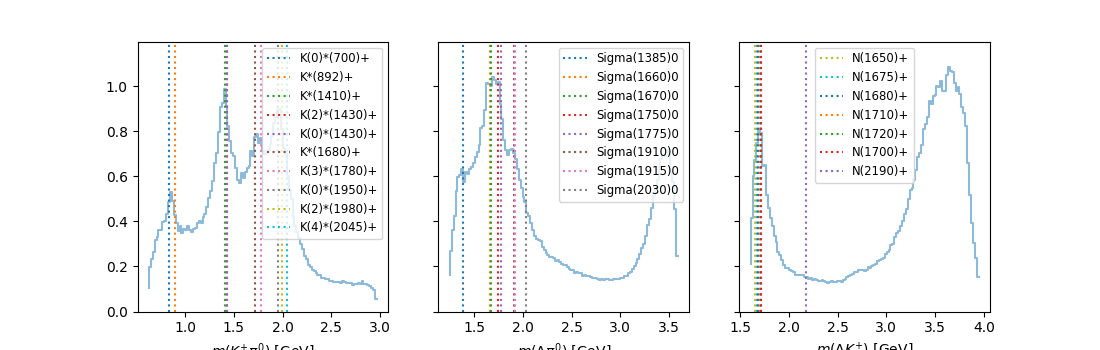

In [20]:
fig, axes = plt.subplots(figsize=(11, 3.5), ncols=3, sharey=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax1, ax2, ax3 = axes

for recoil_id, ax in enumerate(axes):
    decay_products = sorted({0, 1, 2} - {recoil_id})
    product_latex = " ".join([reaction.final_state[i].latex for i in decay_products])
    ax.set_xlabel(f"$m({product_latex})$ [GeV]")

LINES = 3 * [None]
RESONANCE_LINE = [None] * len(reaction.get_intermediate_particles())


def update_plot(**parameters):
    parameters = insert_phi(parameters)
    intensity_func.update_parameters(parameters)
    intensities = intensity_func(phsp)
    max_value = 0
    color_id = 0
    for recoil_id, ax in enumerate(axes):
        decay_products = sorted({0, 1, 2} - {recoil_id})
        key = f"m_{''.join(str(i) for i in decay_products)}"
        bin_values, bin_edges = jax.numpy.histogram(
            phsp[key].real,
            bins=120,
            density=True,
            weights=intensities,
        )
        max_value = max(max_value, bin_values.max())

        if LINES[recoil_id] is None:
            LINES[recoil_id] = ax.step(bin_edges[:-1], bin_values, alpha=0.5)[0]
        else:
            LINES[recoil_id].set_ydata(bin_values)

        for resonance in resonances[recoil_id]:
            key = f"m_{{{resonance.latex}}}"
            val = parameters.get(key, resonance.mass)
            if RESONANCE_LINE[color_id] is None:
                RESONANCE_LINE[color_id] = ax.axvline(
                    val,
                    c=f"C{color_id}",
                    ls="dotted",
                    label=resonance.name,
                )
            else:
                RESONANCE_LINE[color_id].set_xdata([val, val])
            color_id += 1

    for ax in axes:
        ax.set_ylim(0, max_value * 1.1)

    fig.canvas.draw()


w.interactive_output(update_plot, sliders)
for ax in axes:
    ax.legend(fontsize="small")

if STATIC_PAGE:
    filename = "histogram.svg"
    fig.savefig(filename)
    plt.close(fig)
    display(UI, SVG(filename))
else:
    display(UI, fig.canvas)